<a href="https://colab.research.google.com/github/ramoants254/0.-Imdb-Review-nlp/blob/main/0_imdb_review_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from collections import Counter
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel
from sklearn.metrics import confusion_matrix,classification_report

<ipython-input-38-1c7204f2ce24>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Dataset Loading and Preprocessing
* The dataset s from Tensorflow Datasets (https://www.tensorflow.org/datasets/catalog/imdb_reviews)


In [2]:
(train_ds,test_ds),ds_info=tfds.load('imdb_reviews',
                                     split=['train','test'],
                                     as_supervised=True,
                                     with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.M05A2D_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.M05A2D_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.M05A2D_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [4]:
data=[]
for review,label in train_ds.take(5):
  data.append({
      'review':review.numpy().decode('utf-8'),
      'label':label.numpy()
  })

pd.DataFrame(data)


,review,label
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


In [5]:
ds_info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir=PosixGPath('/tmp/tmpyuzxovk2tfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInfo

## finding the total unique words in the dataset

In [6]:
vocab_counter = Counter()
for review, _ in train_ds:
    tokens = tf.strings.split(review).numpy()  # split the review into tokens
    vocab_counter.update(tokens)

print(f'Total unique words in dataset: {len(vocab_counter)}')


Total unique words in dataset: 281131


## Finding the average Review length of the dataset

In [7]:
review_length = [len(tf.strings.split(review).numpy()) for review, _ in train_ds]
print(f'Maximum review length: {max(review_length)}')
print(f'Minimum review length: {min(review_length)}')
print(f'Average review length: {np.mean(review_length)}')


Maximum review length: 2470
Minimum review length: 10
Average review length: 233.77856


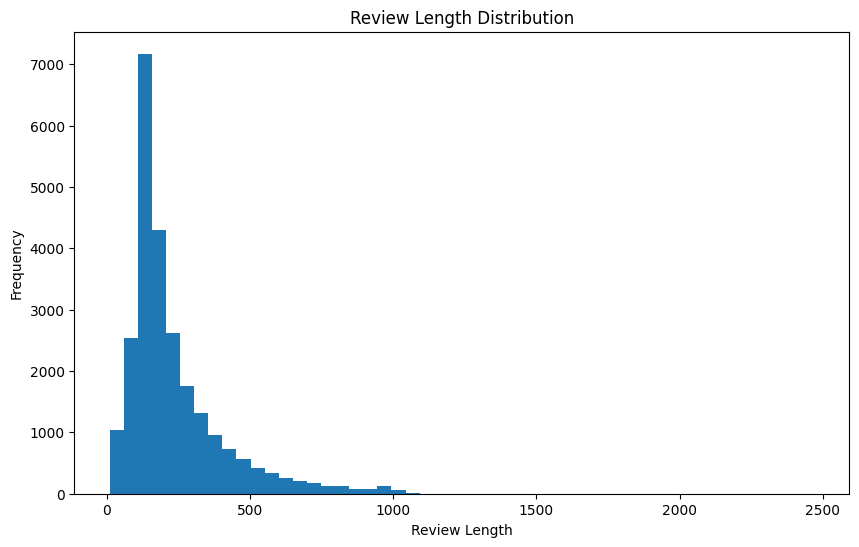

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(review_length, bins=50)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Review Length Distribution')
plt.show()

## Text Vectorization:
 * Convert text data into numerical values using tf.keras.layers.TextVectorization.

In [10]:
max_len=400
max_features=20000

vectorizor=tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_len
)


train_text=train_ds.map(lambda text,label:text)
vectorizor.adapt(train_text)

In [11]:
def vectorize_text(text,label):
  # text=tf.expand_dims(text,-1)
  return vectorizor(text),label

train_ds=train_ds.map(vectorize_text)
test_ds=test_ds.map(vectorize_text)

* Defining Batch size
* creating a callback function,which will stop the training when it has stopped improving

In [12]:
BATCH_SIZE=64
train_ds=train_ds.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds=test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

## Training the model

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features + 1, 16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
history_1=model.fit(train_ds,
          validation_data=test_ds,
                    callbacks=[early_stopping],
          epochs=10)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9073 - loss: 0.3064 - val_accuracy: 0.8765 - val_loss: 0.4470
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9466 - loss: 0.1882 - val_accuracy: 0.8707 - val_loss: 0.5121
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9346 - loss: 0.4165 - val_accuracy: 0.6012 - val_loss: 5.3794


In [28]:
def plot_history(history,acc,val_acc,loss,val_loss):
  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  plt.figure(figsize=(12,8))
  plt.subplot(1,2,1)
  plt.plot(acc,label='Training Accuracy')
  plt.plot(val_acc,label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1,2,2)
  plt.plot(loss,label='Training Loss')
  plt.plot(val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


In [29]:
model.evaluate(test_ds)

391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8750 - loss: 0.4503


[0.44697532057762146, 0.8765199780464172]

In [30]:
model_2=tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features+1,64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])


model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_2=model_2.fit(train_ds,
          validation_data=test_ds,
          callbacks=[early_stopping],
          epochs=10)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - accuracy: 0.6708 - loss: 0.5737 - val_accuracy: 0.8556 - val_loss: 0.3464
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 87ms/step - accuracy: 0.8819 - loss: 0.2972 - val_accuracy: 0.8649 - val_loss: 0.3719
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - accuracy: 0.9168 - loss: 0.2251 - val_accuracy: 0.8546 - val_loss: 0.4141


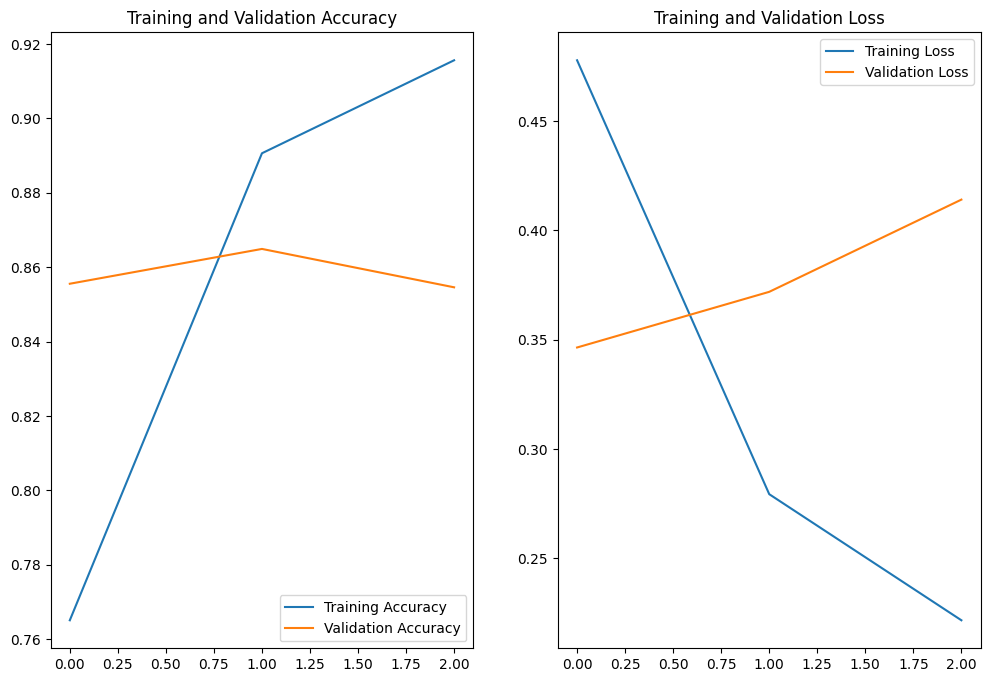

In [31]:
plot_history(history_2,
             history_2.history['accuracy'],
             history_2.history['val_accuracy'],
             history_2.history['loss'],
             history_2.history['val_loss'])

In [32]:
model_2.evaluate(test_ds)

391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.8577 - loss: 0.3445


[0.34641873836517334, 0.8555600047111511]

## Model 3: 1D Convolutional Neural Network (CNN)
* This model can efficiently capture local patterns in the sequence data (like n-grams)

In [33]:
cnn_model=tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features+1,64),
    tf.keras.layers.Conv1D(128,5,activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_3=cnn_model.fit(train_ds,
          validation_data=test_ds,
          callbacks=[early_stopping],
          epochs=10)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.6648 - loss: 0.5700 - val_accuracy: 0.8773 - val_loss: 0.2925
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.9195 - loss: 0.2090 - val_accuracy: 0.8910 - val_loss: 0.2684
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9777 - loss: 0.0819 - val_accuracy: 0.8884 - val_loss: 0.3136


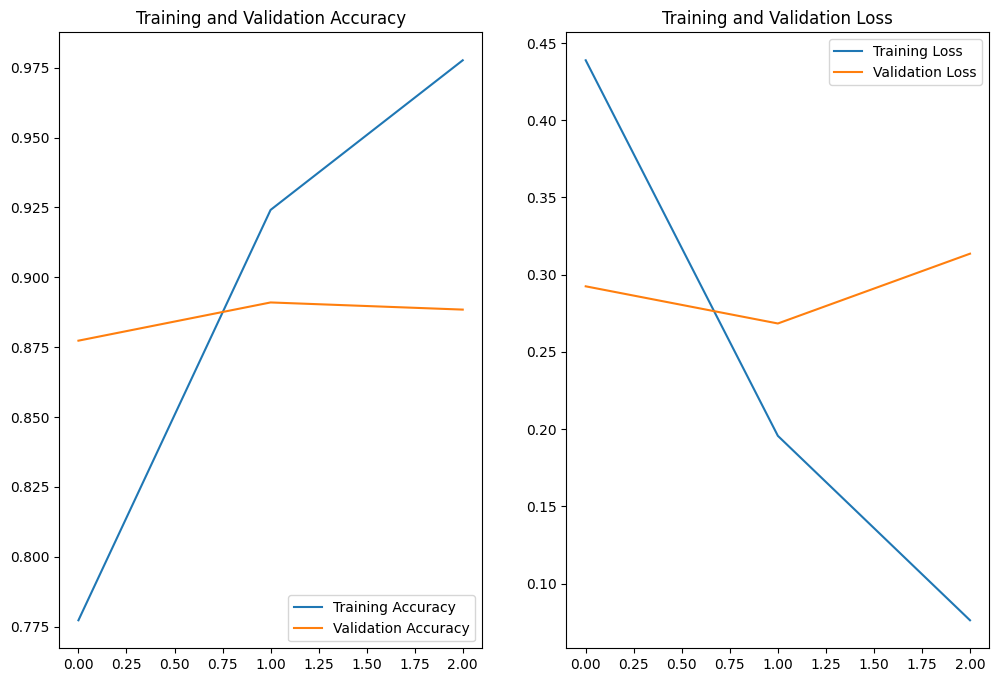

In [34]:
plot_history(history_3,
             history_3.history['accuracy'],
             history_3.history['val_accuracy'],
             history_3.history['loss'],
             history_3.history['val_loss'])

In [35]:
cnn_model.evaluate(test_ds)

391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8752 - loss: 0.2953


[0.29247164726257324, 0.8773199915885925]